## Helsinki City Bike Network

In [1]:
import datetime
import calendar
import warnings

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [2]:
dataframe = pd.read_csv("database.csv", low_memory=False)
dataframe.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9


In [3]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataframe[["distance", "duration", "temperature"]].describe()

,distance,duration,temperature
count,11278850.000,11278850.000,11278850.000
mean,2242.385,783.600,15.637
std,1494.708,795.838,5.495
min,51.000,121.000,-5.200
25%,1121.000,380.000,12.300
50%,1847.000,615.000,16.400
75%,2964.000,991.000,19.300
max,9999.000,17998.000,32.900


In [5]:
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

dataframe[["distance", "duration", "temperature"]].describe()

,distance,duration,temperature
count,11278850.000,11278850.000,11278850.000
mean,2242.385,783.600,15.637
std,1494.708,795.838,5.495
min,51.000,121.000,-5.200
25%,1121.000,380.000,12.300
50%,1847.000,615.000,16.400
75%,2964.000,991.000,19.300
max,9999.000,17998.000,32.900


In [6]:
df = dataframe.copy()

In [7]:
df = df.sort_values(by = "departure")
df['start_time'] = pd.to_datetime(df['departure']).dt.time

In [8]:
year_2016 = dataframe[(dataframe['departure'] >= '2016-01-01') & (dataframe['departure'] <= '2016-12-31')]
year_2017 = dataframe[(dataframe['departure'] >= '2017-01-01') & (dataframe['departure'] <= '2017-12-31')]
year_2018 = dataframe[(dataframe['departure'] >= '2018-01-01') & (dataframe['departure'] <= '2018-12-31')]
year_2019 = dataframe[(dataframe['departure'] >= '2019-01-01') & (dataframe['departure'] <= '2019-12-31')]
year_2020 = dataframe[(dataframe['departure'] >= '2020-01-01') & (dataframe['departure'] <= '2020-12-31')]

In [9]:
year_list = [year_2016,year_2017,year_2018,year_2019,year_2020]
y = [2016,2017,2018,2019,2020]

In [9]:
split_date = pd.datetime(2020,2,26)

df_preCovo = df.loc[df['departure'] <= split_date]
df_postCovo = df.loc[df['departure'] > split_date]

<ipython-input-9-26790da69c7a>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2020,2,26)


In [10]:
# Calculate trip counts per hour on weekdays and weekends
df_sub_pre = df_preCovo.loc[:, ['duration', 'departure']] 
df_sub_pre.index = df_sub_pre['departure']
weekdays = df_sub_pre[df_sub_pre.index.weekday < 6]
weekends = df_sub_pre[df_sub_pre.index.weekday > 5]
weekdays_countsPerHr_pre = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr_pre = weekends.groupby(weekends.index.hour).size()

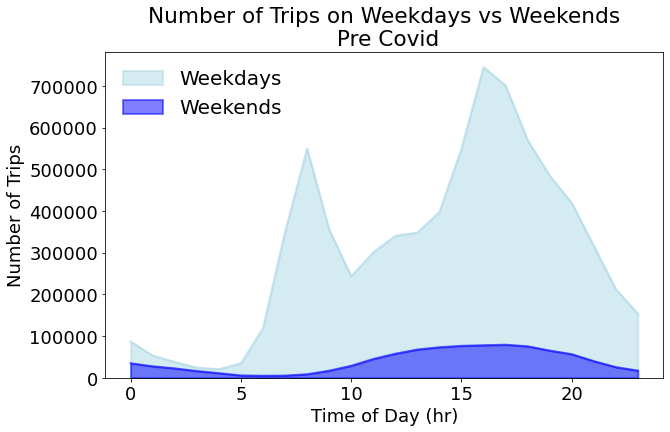

In [23]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr_pre.plot(kind = 'area', stacked = False, figsize = (10, 6), color = 'lightblue',
                          linewidth = 2, label='Weekdays')

weekends_countsPerHr_pre.plot(kind = 'area', stacked = False, color = 'blue',
                          linewidth = 2, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax = plt.gca()
plt.title('Number of Trips on Weekdays vs Weekends\n Pre Covid')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Number of Trips')
legend = ax.legend(loc='upper left', frameon = False)

In [24]:
# Calculate trip counts per hour on weekdays and weekends
df_sub_post = df_postCovo.loc[:, ['duration', 'departure']] 
df_sub_post.index = df_sub_post['departure']
weekdays = df_sub_post[df_sub_post.index.weekday < 6]
weekends = df_sub_post[df_sub_post.index.weekday > 5]
weekdays_countsPerHr_post = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr_post = weekends.groupby(weekends.index.hour).size()

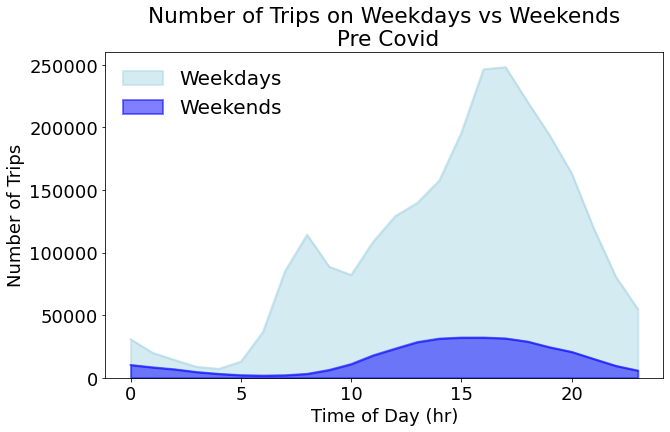

In [25]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr_post.plot(kind = 'area', stacked = False, figsize = (10, 6), color = 'lightblue',
                          linewidth = 2, label='Weekdays')

weekends_countsPerHr_post.plot(kind = 'area', stacked = False, color = 'blue',
                          linewidth = 2, label='Weekends')

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax = plt.gca()
plt.title('Number of Trips on Weekdays vs Weekends\n Pre Covid')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Number of Trips')
legend = ax.legend(loc='upper left', frameon = False)

In [109]:
#Add a new column calculating the number of trips between two stations, start and end.
trips_postCovo = df_postCovo.groupby(['departure_name','return_name']).size().reset_index(name = 'number_of_trips')
trips_postCovo.sort_values('number_of_trips', ascending = False, inplace = True)
trips_postCovo = trips_postCovo.head(10)
trips_postCovo['trip_detail'] = trips_postCovo['departure_name'].astype(str) + ' to ' + trips_postCovo['return_name'].astype(str)
trips_postCovo


#Add a new column calculating the number of trips between two stations, start and end.
trips_preCovo = df_preCovo.groupby(['departure_name','return_name']).size().reset_index(name = 'number_of_trips')
trips_preCovo.sort_values('number_of_trips', ascending = False, inplace = True)
trips_preCovo = trips_preCovo.head(10)
trips_preCovo
#Add a column to dataframe to indicate the trip details 
trips_preCovo['trip_detail'] = trips_preCovo['departure_name'].astype(str) + ' to ' + trips_preCovo['return_name'].astype(str)
trips_preCovo

,departure_name,return_name,number_of_trips,trip_detail
13375,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio",22468,"Jämeräntaival to Aalto-yliopisto (M), Korkeako..."
221,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival,22252,"Aalto-yliopisto (M), Korkeakouluaukio to Jämer..."
12862,Itämerentori,Tyynenmerenkatu,16208,Itämerentori to Tyynenmerenkatu
12710,Itämerentori,Itämerentori,15848,Itämerentori to Itämerentori
47276,Tyynenmerenkatu,Itämerentori,15177,Tyynenmerenkatu to Itämerentori
47833,Töölönlahdenkatu,Baana,14684,Töölönlahdenkatu to Baana
12865,Itämerentori,Töölönlahdenkatu,14617,Itämerentori to Töölönlahdenkatu
47879,Töölönlahdenkatu,Itämerentori,14287,Töölönlahdenkatu to Itämerentori
12832,Itämerentori,Salmisaarenranta,14039,Itämerentori to Salmisaarenranta
2841,Baana,Töölönlahdenkatu,13933,Baana to Töölönlahdenkatu


Text(0, 0.5, 'Trip Detail')

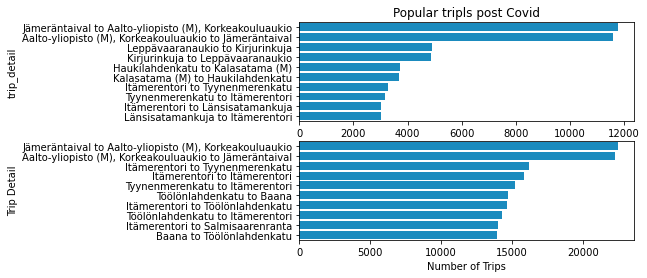

In [122]:
#Plot the most popular trips
fig, axs = plt.subplots(nrows=2)
plotPost = sns.barplot(data = trips_postCovo
            ,x = 'number_of_trips'
            ,y = 'trip_detail',color = '#0095d9', ax=axs[0]
            ).set_title('Popular tripls post Covid')
plt.xlabel('Number of Trips')
plt.ylabel('Trip Detail')

plotPre = sns.barplot(data = trips_preCovo
            ,x = 'number_of_trips'
            ,y = 'trip_detail',color = '#0095d9', ax=axs[1]
            ).set_title('')
plt.xlabel('Number of Trips')
plt.ylabel('Trip Detail')



In [22]:
temp = pd.DatetimeIndex(df_preCovo['departure'])
df_preCovo['Date'] = temp.date
df_preCovo['Time'] = temp.time


<ipython-input-22-76eab8ff7f92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preCovo['Date'] = temp.date
<ipython-input-22-76eab8ff7f92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preCovo['Time'] = temp.time


## Comparison first saturday of April 2020  vs first saturday April 2018

In [140]:
df_time_post1 = df_postCovo
df_time_post1 = (df_time_post1['departure'] >= '2020-04-04 00:00') & (df_time_post1['departure'] < '2020-04-05 23:59')
df_time_post1 = df_postCovo.loc[df_time_post1]
df_time_post1



,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,speed,departure_latitude,departure_longitude,return_latitude,return_longitude,temperature,start_time
50602,2020-04-04 00:03:29,2020-04-04 00:09:34,263,Herttoniemen kirkko,265.0,Siilitie 9,1378.000,361.000,0.229,60.198,25.032,60.209,25.037,0.600,00:03:29
50603,2020-04-04 00:03:44,2020-04-04 00:30:47,26,Kamppi (M),129.0,Pernajantie,3918.000,1619.000,0.145,60.169,24.931,60.194,24.958,0.600,00:03:44
50604,2020-04-04 00:06:20,2020-04-04 00:32:36,26,Kamppi (M),32.0,Eläinmuseo,4687.000,1577.000,0.178,60.169,24.931,60.171,24.932,0.600,00:06:20
50605,2020-04-04 00:07:11,2020-04-04 01:34:12,12,Kanavaranta,63.0,Jätkäsaarenlaituri,2434.000,5216.000,0.028,60.168,24.958,60.162,24.921,0.600,00:07:11
50606,2020-04-04 00:08:16,2020-04-04 00:20:53,15,Ritarikatu,37.0,Töölönkatu,2356.000,753.000,0.188,60.171,24.956,60.178,24.928,0.600,00:08:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66979,2020-04-05 23:49:03,2020-04-05 23:55:46,19,Rautatientori / itä,69.0,Kalevankatu,1014.000,399.000,0.152,60.171,24.943,60.166,24.931,3.200,23:49:03
66980,2020-04-05 23:49:47,2020-04-05 23:56:33,135,Velodrominrinne,113.0,Pasilan asema,848.000,403.000,0.126,60.201,24.944,60.198,24.933,3.200,23:49:47
66981,2020-04-05 23:50:55,2020-04-05 23:56:51,135,Velodrominrinne,113.0,Pasilan asema,802.000,350.000,0.137,60.201,24.944,60.198,24.933,3.200,23:50:55
66982,2020-04-05 23:56:11,2020-04-05 23:59:55,281,Puotila (M),274.0,Voikukantie,925.000,224.000,0.248,60.215,25.091,60.209,25.087,3.200,23:56:11


In [139]:
df_time_pre1 = df_preCovo
df_time_pre1 = (df_time_pre1['departure'] >= '2018-04-07 00:00') & (df_time_pre1['departure'] < '2018-04-08 23:59')
df_time_pre1 = df_postCovo.loc[df_time_pre1]
df_time_pre1


,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,speed,departure_latitude,departure_longitude,return_latitude,return_longitude,temperature,start_time
1900465,2020-08-07 15:07:33,2020-08-07 15:18:03,87,Kustaankatu,150.0,Töölönlahden puisto,2354.000,626.000,0.226,60.188,24.956,60.175,24.935,20.200,15:07:33
1900466,2020-08-07 15:07:33,2020-08-07 15:28:56,57,Lauttasaaren ostoskeskus,541.0,"Aalto-yliopisto (M), Korkeakouluaukio",5277.000,1277.000,0.248,60.160,24.882,60.184,24.827,20.200,15:07:33
1900467,2020-08-07 15:07:36,2020-08-07 15:19:33,14,Senaatintori,201.0,Länsisatamankuja,2942.000,718.000,0.246,60.169,24.953,60.157,24.912,20.200,15:07:36
1900468,2020-08-07 15:07:36,2020-08-07 15:16:53,275,Itäkeskus (M),278.0,Puotilantie,1880.000,551.000,0.205,60.210,25.076,60.209,25.100,20.200,15:07:36
1900469,2020-08-07 15:07:37,2020-08-07 15:16:06,8,Vanha kirkkopuisto,63.0,Jätkäsaarenlaituri,1212.000,504.000,0.144,60.165,24.939,60.162,24.921,20.200,15:07:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908424,2020-08-07 20:23:56,2020-08-07 20:38:35,19,Rautatientori / itä,66.0,Ehrenströmintie,2491.000,875.000,0.171,60.171,24.943,60.155,24.959,20.400,20:23:56
1908425,2020-08-07 20:24:03,2020-08-07 20:35:24,18,Porthania,30.0,Itämerentori,2693.000,676.000,0.239,60.170,24.948,60.164,24.915,20.400,20:24:03
1908426,2020-08-07 20:24:03,2020-08-07 20:33:29,19,Rautatientori / itä,63.0,Jätkäsaarenlaituri,2076.000,548.000,0.227,60.171,24.943,60.162,24.921,20.400,20:24:03
1908427,2020-08-07 20:24:03,2020-08-07 20:33:43,150,Töölönlahden puisto,150.0,Töölönlahden puisto,161.000,575.000,0.017,60.175,24.935,60.175,24.935,20.400,20:24:03


In [59]:
#df_time24_post.reset_index(drop=True, inplace=True)
#Calculate the number of trips for start station to end station
tripcount_post_df = df_time_post1.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_post_df.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_post_df['edge_weight'] = list(zip(tripcount_post_df['departure_name'], tripcount_post_df['return_name'],tripcount_post_df['Number of Trips']))
tripcount_post_df.head(5)




,departure_name,return_name,departure_latitude,departure_longitude,return_latitude,return_longitude,Number of Trips,edge_weight
10,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival,60.184,24.827,60.188,24.835,41,"(Aalto-yliopisto (M), Korkeakouluaukio, Jämerä..."
2056,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio",60.188,24.835,60.184,24.827,34,"(Jämeräntaival, Aalto-yliopisto (M), Korkeakou..."
2854,Kirjurinkuja,Leppävaaranaukio,60.217,24.826,60.219,24.815,29,"(Kirjurinkuja, Leppävaaranaukio, 29)"
3764,Leppävaaranaukio,Kirjurinkuja,60.219,24.815,60.217,24.826,25,"(Leppävaaranaukio, Kirjurinkuja, 25)"
263,Arabian kauppakeskus,Kalasatama (M),60.203,24.967,60.188,24.977,23,"(Arabian kauppakeskus, Kalasatama (M), 23)"


In [60]:
#df_time24_post.reset_index(drop=True, inplace=True)
#Calculate the number of trips for start station to end station
tripcount_pre_df = df_time_pre1.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_pre_df.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_pre_df['edge_weight'] = list(zip(tripcount_pre_df['departure_name'], tripcount_pre_df['return_name'],tripcount_pre_df['Number of Trips']))
tripcount_pre_df.head(5)


,departure_name,return_name,departure_latitude,departure_longitude,return_latitude,return_longitude,Number of Trips,edge_weight
16,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival,60.184,24.827,60.188,24.835,49,"(Aalto-yliopisto (M), Korkeakouluaukio, Jämerä..."
1248,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio",60.188,24.835,60.184,24.827,29,"(Jämeräntaival, Aalto-yliopisto (M), Korkeakou..."
2283,Leppävaaranaukio,Kirjurinkuja,60.219,24.815,60.217,24.826,19,"(Leppävaaranaukio, Kirjurinkuja, 19)"
1817,Kirjurinkuja,Leppävaaranaukio,60.217,24.826,60.219,24.815,16,"(Kirjurinkuja, Leppävaaranaukio, 16)"
660,Gyldenintie,Heikkilänaukio,60.158,24.877,60.154,24.879,12,"(Gyldenintie, Heikkilänaukio, 12)"


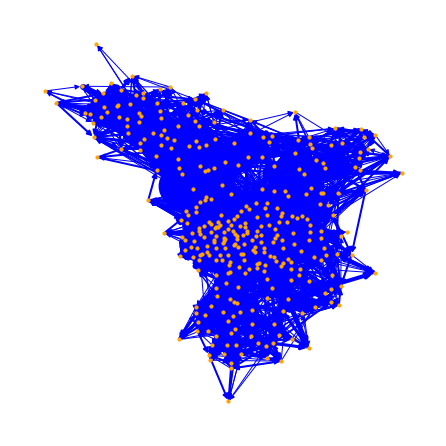

In [101]:
# Graph First saturday of April 2020
trips_graph = tripcount_post_df
edge_weight = trips_graph['edge_weight']
wg = nx.DiGraph()
wg.add_weighted_edges_from(edge_weight)
weights = [wg[u][v]['weight'] for u,v in wg.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg, node_size=10, with_labels=False,node_color='orange', width = weights, edge_color='blue')
plt.show()


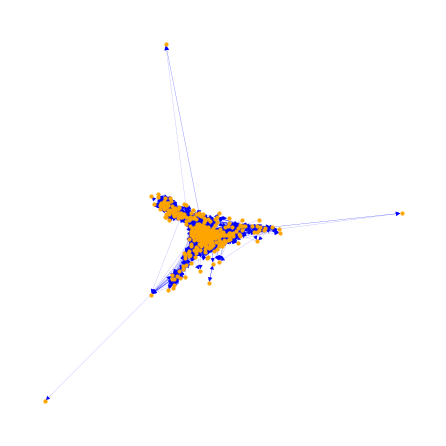

In [102]:
# Graph first saturday of April 2018
trips_graph = tripcount_pre_df
edge_weight = trips_graph['edge_weight']
wg1 = nx.DiGraph()
wg1.add_weighted_edges_from(edge_weight)
weights1 = [wg1[u][v]['weight'] for u,v in wg1.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg1, node_size=10, with_labels=False,node_color='orange', width = weights1, edge_color='blue')
plt.show()


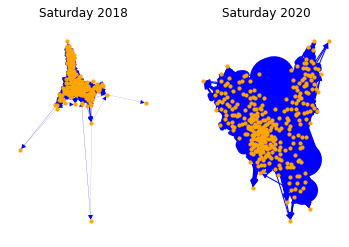

In [74]:
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_title('First April Saturday 2018')
nx.draw(wg1, node_size=10, with_labels=False,node_color='orange', width = weights1, edge_color='blue', ax = ax)
plt.subplot(1,2,2)
ax = plt.gca()
ax.set_title('First April Saturday 2020')
nx.draw(wg, node_size=10, with_labels=False,node_color='orange', width = weights, edge_color='blue', ax = ax)

In [76]:
df_time_post2 = df_postCovo
df_time_post2 = (df_time_post2['departure'] >= '2020-04-06 00:00') & (df_time_post2['departure'] < '2020-04-07 23:59')
df_time_post2 = df_postCovo.loc[df_time_post2]
df_time_post2


df_time_pre2 = df_preCovo
df_time_pre2 = (df_time_pre2['departure'] >= '2018-04-09 00:00') & (df_time_pre2['departure'] < '2018-04-10 23:59')
df_time_pre2 = df_postCovo.loc[df_time_pre2]
df_time_pre2



,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,speed,departure_latitude,departure_longitude,return_latitude,return_longitude,temperature,start_time
1908429,2020-08-07 20:24:14,2020-08-07 20:30:05,94,Laajalahden aukio,92.0,Saunalahdentie,818.000,346.000,0.142,60.198,24.876,60.193,24.879,20.400,20:24:14
1908430,2020-08-07 20:24:16,2020-08-07 20:30:38,747,Leppävaaran uimahalli,731.0,Leppävaarankäytävä,1065.000,378.000,0.169,60.226,24.805,60.220,24.813,20.400,20:24:16
1908431,2020-08-07 20:24:22,2020-08-07 20:52:31,134,Haukilahdenkatu,11.0,Unioninkatu,4647.000,1683.000,0.166,60.199,24.968,60.167,24.951,20.400,20:24:22
1908432,2020-08-07 20:24:23,2020-08-07 21:22:43,150,Töölönlahden puisto,150.0,Töölönlahden puisto,144.000,3496.000,0.002,60.175,24.935,60.175,24.935,20.400,20:24:23
1908433,2020-08-07 20:24:24,2020-08-07 20:39:29,126,Kalasatama (M),138.0,Arabiankatu,2691.000,900.000,0.179,60.188,24.977,60.206,24.977,20.400,20:24:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921628,2020-08-08 16:35:20,2020-08-08 16:42:59,293,Korkeasaari,121.0,Vilhonvuorenkatu,1544.000,458.000,0.202,60.180,24.983,60.186,24.968,24.400,16:35:20
1921629,2020-08-08 16:35:23,2020-08-08 16:39:59,54,Gyldenintie,143.0,Kuikkarinne,465.000,271.000,0.103,60.158,24.877,60.157,24.869,24.400,16:35:23
1921630,2020-08-08 16:35:25,2020-08-08 17:01:56,206,Ruskeasuon varikko,82.0,Töölöntulli,2858.000,1586.000,0.108,60.208,24.899,60.191,24.913,24.400,16:35:25
1921631,2020-08-08 16:35:27,2020-08-08 16:55:05,50,Melkonkuja,201.0,Länsisatamankuja,3696.000,1172.000,0.189,60.150,24.886,60.157,24.912,24.400,16:35:27


In [77]:
#df_time24_post.reset_index(drop=True, inplace=True)
#Calculate the number of trips for start station to end station
tripcount_post_weekd = df_time_post2.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_post_weekd.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_post_weekd['edge_weight'] = list(zip(tripcount_post_weekd['departure_name'], tripcount_post_weekd['return_name'],tripcount_post_weekd['Number of Trips']))
tripcount_post_weekd.head(5)

#df_time24_post.reset_index(drop=True, inplace=True)
#Calculate the number of trips for start station to end station
tripcount_pre_weekd = df_time_pre2.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_pre_weekd.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_pre_weekd['edge_weight'] = list(zip(tripcount_pre_weekd['departure_name'], tripcount_pre_weekd['return_name'],tripcount_pre_weekd['Number of Trips']))
tripcount_pre_weekd.head(5)





,departure_name,return_name,departure_latitude,departure_longitude,return_latitude,return_longitude,Number of Trips,edge_weight
1824,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio",60.188,24.835,60.184,24.827,39,"(Jämeräntaival, Aalto-yliopisto (M), Korkeakou..."
12,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival,60.184,24.827,60.188,24.835,39,"(Aalto-yliopisto (M), Korkeakouluaukio, Jämerä..."
2080,Kalasatama (M),Isoisänsilta,60.188,24.977,60.183,24.982,23,"(Kalasatama (M), Isoisänsilta, 23)"
7062,Vilhonvuorenkatu,Isoisänsilta,60.186,24.968,60.183,24.982,22,"(Vilhonvuorenkatu, Isoisänsilta, 22)"
3298,Leppävaaranaukio,Kirjurinkuja,60.219,24.815,60.217,24.826,21,"(Leppävaaranaukio, Kirjurinkuja, 21)"


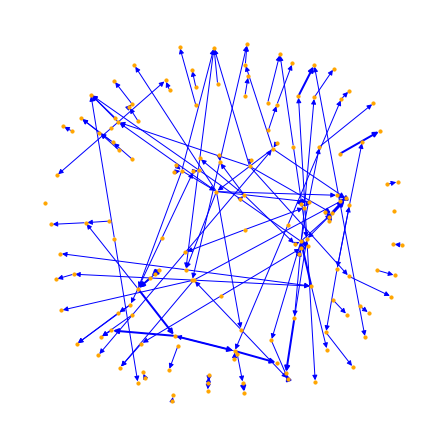

In [99]:
# Graphs of Monday 2020 April 
trips_graph = tripcount_post_weekd
edge_weight = trips_graph['edge_weight']
wg2 = nx.DiGraph()
wg2.add_weighted_edges_from(edge_weight)
weights2 = [wg2[u][v]['weight'] for u,v in wg2.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg2, node_size=10, with_labels=False,node_color='orange', width = weights2, edge_color='blue')
plt.show()


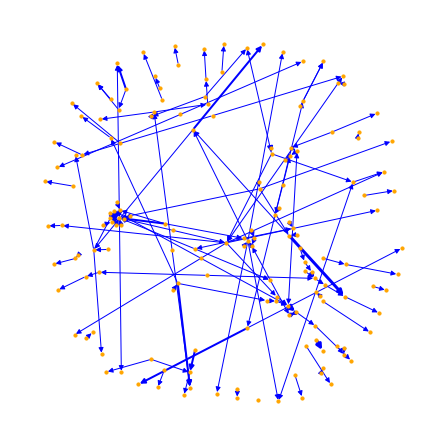

In [97]:
# Graphs of  Monday 2018 April
trips_graph = tripcount_pre_weekd
edge_weight = trips_graph['edge_weight']
wg3 = nx.DiGraph()
wg3.add_weighted_edges_from(edge_weight)
weights3 = [wg3[u][v]['weight'] for u,v in wg3.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg3, node_size=10, with_labels=False,node_color='orange', width = weights3, edge_color='blue')
plt.show()


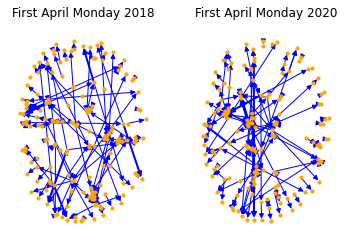

In [100]:
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_title('First April Monday 2018')
nx.draw(wg3, node_size=10, with_labels=False,node_color='orange', width = weights3, edge_color='blue', ax = ax)
plt.subplot(1,2,2)
ax = plt.gca()
ax.set_title('First April Monday 2020')
nx.draw(wg2, node_size=10, with_labels=False,node_color='orange', width = weights2, edge_color='blue', ax = ax)

In [89]:

df_time_post3 = df_postCovo
df_time_post3 = (df_time_post3['departure'] >= '2020-04-05 00:00') & (df_time_post3['departure'] < '2020-04-05 05:59')
df_time_post3 = df_postCovo.loc[df_time_post3]



df_time_pre3 = df_preCovo
df_time_pre3 = (df_time_pre3['departure'] >= '2018-04-08 00:00') & (df_time_pre3['departure'] < '2018-04-08 05:59')
df_time_pre3 = df_postCovo.loc[df_time_pre3]
print(df_time_pre3,df_time_pre3)


                  departure              return departure_id  \
1904387 2020-08-07 17:32:31 2020-08-07 17:37:45          613   
1904388 2020-08-07 17:32:31 2020-08-07 17:55:14           63   
1904389 2020-08-07 17:32:34 2020-08-07 17:57:37          134   
1904390 2020-08-07 17:32:39 2020-08-07 17:40:44           18   
1904391 2020-08-07 17:32:39 2020-08-07 17:43:09          113   
...                     ...                 ...          ...   
1904701 2020-08-07 17:42:57 2020-08-07 17:54:18           21   
1904702 2020-08-07 17:43:01 2020-08-07 18:03:46           41   
1904703 2020-08-07 17:43:02 2020-08-07 17:58:09          243   
1904704 2020-08-07 17:43:17 2020-08-07 17:48:35          581   
1904705 2020-08-07 17:43:18 2020-08-07 17:50:34          627   

             departure_name return_id               return_name  distance  \
1904387       Matinkyläntie     601.0                   Nokkala  1087.000   
1904388  Jätkäsaarenlaituri     120.0               Mäkelänkatu  4902.000   


In [90]:
#Calculate the number of trips for start station to end station (weekend - 00 till 4)
tripcount_post_weekd24 = df_time_post3.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_post_weekd24.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_post_weekd24['edge_weight'] = list(zip(tripcount_post_weekd24['departure_name'], tripcount_post_weekd24['return_name'],tripcount_post_weekd24['Number of Trips']))
tripcount_post_weekd24.head(5)

#Calculate the number of trips for start station to end station (weekend - 00 till 4)
tripcount_pre_weekd24 = df_time_pre3.groupby(['departure_name','return_name','departure_latitude','departure_longitude','return_latitude','return_longitude']).size().reset_index(name = 'Number of Trips')
tripcount_pre_weekd24.sort_values('Number of Trips', ascending = False, inplace = True)
tripcount_pre_weekd24['edge_weight'] = list(zip(tripcount_pre_weekd24['departure_name'], tripcount_pre_weekd24['return_name'],tripcount_pre_weekd24['Number of Trips']))
tripcount_pre_weekd24.head(5)



,departure_name,return_name,departure_latitude,departure_longitude,return_latitude,return_longitude,Number of Trips,edge_weight
70,Kaivopuisto,Hernesaarenranta,60.155,24.950,60.154,24.931,6,"(Kaivopuisto, Hernesaarenranta, 6)"
161,Nordenskiöldinaukio,Hietalahdentori,60.185,24.917,60.162,24.930,4,"(Nordenskiöldinaukio, Hietalahdentori, 4)"
35,Hakaniemi (M),Rautatientori / itä,60.178,24.952,60.171,24.943,3,"(Hakaniemi (M), Rautatientori / itä, 3)"
66,Jämeräntaival,Lumivaarantie,60.188,24.835,60.205,24.814,3,"(Jämeräntaival, Lumivaarantie, 3)"
78,Kalasatama (M),Isoisänsilta,60.188,24.977,60.183,24.982,3,"(Kalasatama (M), Isoisänsilta, 3)"


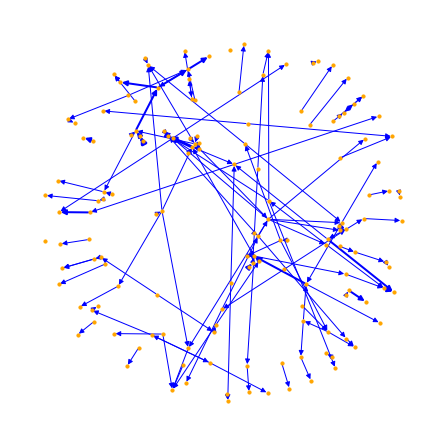

In [92]:
trips_graph = tripcount_post_weekd24
edge_weight = trips_graph['edge_weight']
wg4 = nx.DiGraph()
wg4.add_weighted_edges_from(edge_weight)
weights4 = [wg4[u][v]['weight'] for u,v in wg4.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg4, node_size=10, with_labels=False,node_color='orange', width = weights4, edge_color='blue')
plt.show()


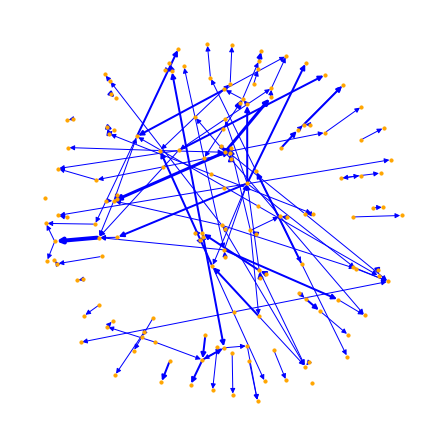

In [93]:
trips_graph = tripcount_pre_weekd24
edge_weight = trips_graph['edge_weight']
wg5 = nx.DiGraph()
wg5.add_weighted_edges_from(edge_weight)
weights5 = [wg5[u][v]['weight'] for u,v in wg5.edges()]
myInt = 10
weights1[:] = [x / myInt for x in weights1]
plt.figure(2,figsize=(6,6))
nx.draw(wg3, node_size=10, with_labels=False,node_color='orange', width = weights5, edge_color='blue')
plt.show()

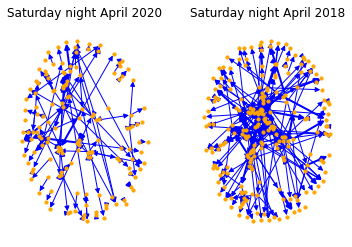

In [95]:
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_title('First Saturday night April 2020')
nx.draw(wg4, node_size=10, with_labels=False,node_color='orange', width = weights4, edge_color='blue', ax = ax)
plt.subplot(1,2,2)
ax = plt.gca()
ax.set_title('First Saturday night April 2018')
nx.draw(wg5, node_size=10, with_labels=False,node_color='orange', width = weights5, edge_color='blue', ax = ax)

In [ ]:
import decorator
print('decorator: {}'.format(decorator.__version__))

In [14]:
!pip install decorator


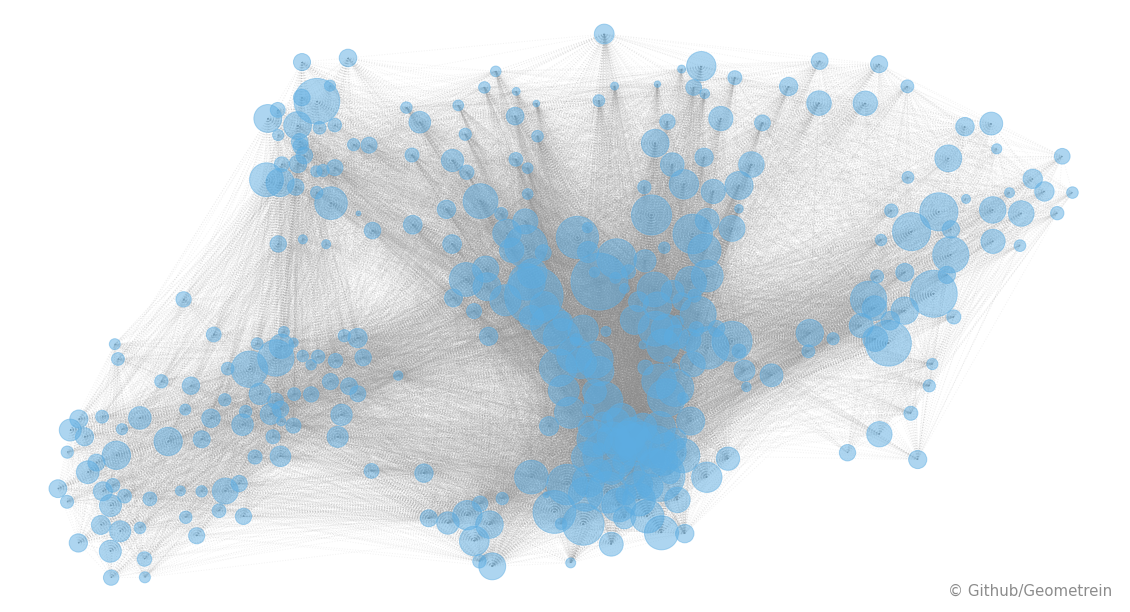

In [104]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = df_postCovo.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return G

G = bikeNetwork(dataframe)


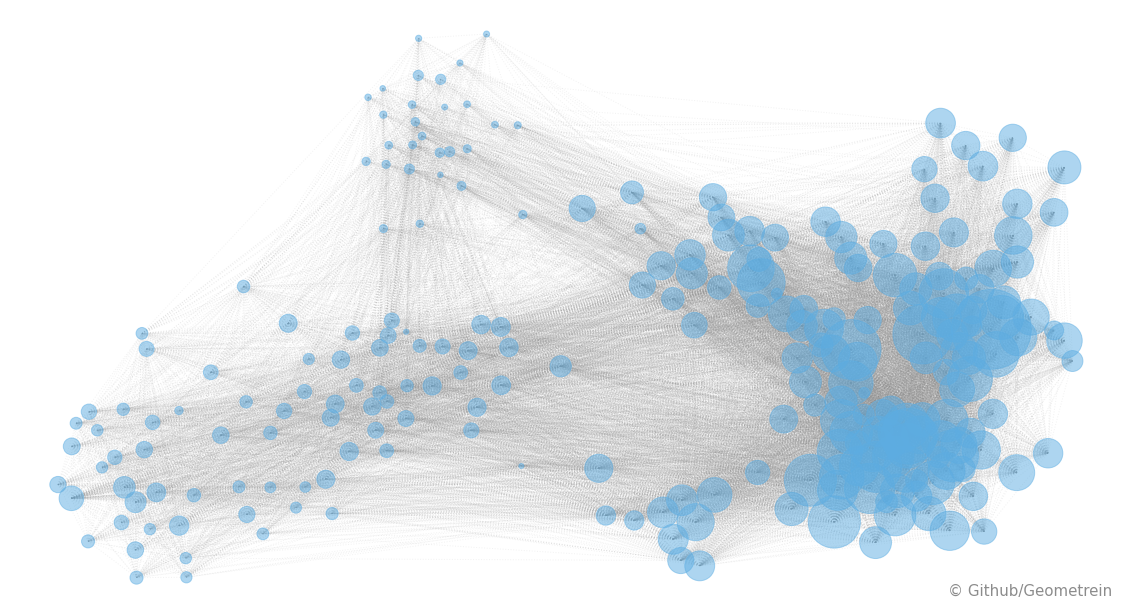

In [105]:
def bikeNetwork(dataframe, year=2018):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = df_preCovo.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return G

G = bikeNetwork(dataframe)


## Number of trips classification

In [10]:
trips_post = df_postCovo.groupby('departure_name').size().reset_index(name = 'number_of_trips')
trips_post.sort_values('number_of_trips', ascending = False, inplace = True)
trips_post.columns=['departure_name','number_of_trips']
trips_post

NameError: name 'df_postCovo' is not defined

Text(0, 0.5, 'Count')

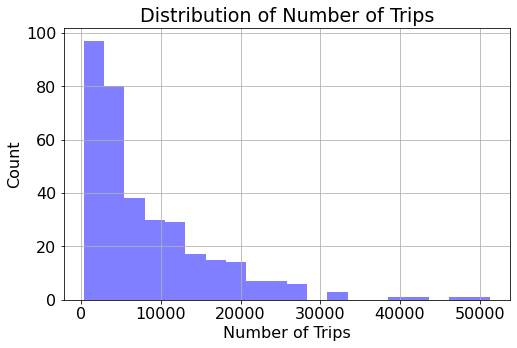

In [130]:
# Plot the distribution of number of trips post covid
plt.rcParams.update({'font.size': 16})
trips_post['number_of_trips'].hist(figsize = (8,5), bins = 20, alpha = 0.5, color = 'blue')
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Count')

In [129]:
trips_pre = df_preCovo.groupby('departure_name').size().reset_index(name = 'number_of_trips')
trips_pre.sort_values('number_of_trips', ascending = False, inplace = True)
trips_pre.columns=['departure_name','number_of_trips']
trips_pre

,departure_name,number_of_trips
81,Itämerentori,256011
309,Töölönlahdenkatu,185548
95,Kamppi (M),158596
251,Rautatientori / länsi,129503
340,Ympyrätalo,120739
...,...,...
173,Marjaniemi,1461
45,Haakoninlahdenkatu,1013
27,Elfvik,875
117,Koskelan varikko,855


Text(0, 0.5, 'Count')

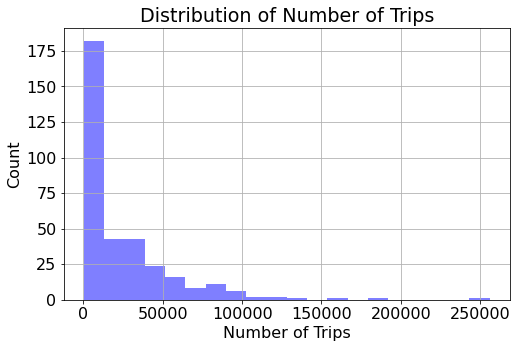

In [131]:
# Plot the distribution of number of trips pre covid
plt.rcParams.update({'font.size': 16})
trips_pre['number_of_trips'].hist(figsize = (8,5), bins = 20, alpha = 0.5, color = 'blue')
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Count')

In [132]:
trips = dataframe.groupby('departure_name').size().reset_index(name = 'number_of_trips')
trips.sort_values('number_of_trips', ascending = False, inplace = True)
trips.columns=['departure_name','number_of_trips']
trips

,departure_name,number_of_trips
82,Itämerentori,307267
315,Töölönlahdenkatu,227943
97,Kamppi (M),189954
257,Rautatientori / länsi,160881
346,Ympyrätalo,160268
...,...,...
28,Elfvik,2264
48,Hagalundinpuisto,2190
80,Itäkeskus Metrovarikko,1175
220,Outotec,1071


Text(0, 0.5, 'Count')

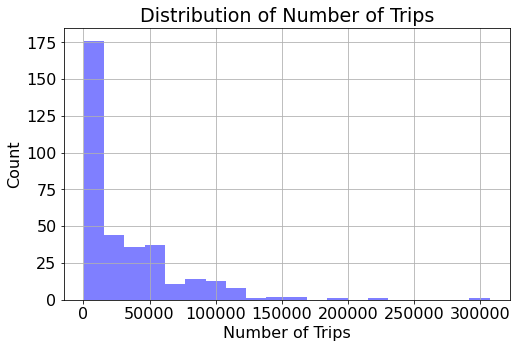

In [133]:
# Plot the distribution of number of trips pre covid
plt.rcParams.update({'font.size': 16})
trips['number_of_trips'].hist(figsize = (8,5), bins = 20, alpha = 0.5, color = 'blue')
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Count')

## Network Modelling

In [ ]:
# Covid network
def bikeNetwork(dataframe, year):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])


    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stations  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stations.set_index('name',inplace=True)
    stations["pos"] = list(zip(stations["longitude"].astype(float), stations["latitude"].astype(float)))
    pos = stations.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass
    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    nx.draw_networkx_labels(G=G, pos=G.nodes.data('pos'),font_size=9,font_color='white',alpha=0.5)
    ax.axis('off')

    return G


y16 = bikeNetwork(year_2016,2016)
y17 = bikeNetwork(year_2017,2017)
y18 = bikeNetwork(year_2018,2018)
y19 = bikeNetwork(year_2019,2019)
y20 = bikeNetwork(year_2020,2020)

In [ ]:
data_list = [year_2016,year_2017,year_2018,year_2019,year_2020]
network_list = [y16,y17,y18,y19,y20]

for i in range(5):
    print(f"year {y[i]} : {nx.info(network_list[i])}")

In [15]:
centrality = nx.degree_centrality(y20)
betweenness = nx.betweenness_centrality(y20)
closeness = nx.closeness_centrality(y20)


NameError: name 'y20' is not defined

In [ ]:
betweenness = pd.DataFrame(betweenness.items(), columns=['departure_name', 'Betweenness'])
betweenness.sort_values('departure_name', ascending = False, inplace = True)

centrality = pd.DataFrame(centrality.items(), columns=['departure_name', 'centrality'])
centrality.sort_values('departure_name', ascending = False, inplace = True)

degree = pd.DataFrame(degree.items(), columns=['departure_name', 'degree'])
degree.sort_values('departure_name', ascending = False, inplace = True)


In [11]:
trips_ = year_2020.groupby(['departure_name']).size().reset_index(name = 'number_of_trips')
trips_.sort_values('departure_name', ascending = False, inplace = True)
trips_

,departure_name,number_of_trips
346,Ympyrätalo,39529
345,Yhdyskunnankuja,3382
344,Westendintie,2649
343,Westendinasema,5147
342,Von Daehnin katu,1542
...,...,...
4,Agnetankuja,6725
3,Abraham Wetterin tie,5025
2,"Aalto-yliopisto (M), Tietotie",4343
1,"Aalto-yliopisto (M), Korkeakouluaukio",26621


In [13]:
pd.merge(trips_,betweenness,left_index=True, right_index=True)

NameError: name 'betweenness' is not defined

In [82]:
trips_.set_index('departure_name').join(betweenness.set_index('departure_name'),centrality.set_index('departure_name'))


KeyError:                                        centrality
departure_name                                   
Ympyrätalo                                  0.711
Yhdyskunnankuja                             0.425
Westendintie                                0.321
Westendinasema                              0.474
Von Daehnin katu                            0.275
...                                           ...
Agnetankuja                                 0.390
Abraham Wetterin tie                        0.399
Aalto-yliopisto (M), Tietotie               0.503
Aalto-yliopisto (M), Korkeakouluaukio       0.676
A.I. Virtasen aukio                         0.590

[347 rows x 1 columns]

In [69]:
centrality

,Departure,centrality
0,Kuusitie,0.720
1,Esterinportti,0.740
2,Kamppi (M),0.662
3,Kasarmitori,0.529
4,Porolahden koulu,0.376
...,...,...
342,Ida Aalbergin tie,0.434
343,Hämeenlinnanväylä,0.532
344,Kustaankartano,0.399
345,Kaapelitehdas,0.575
